#  **ECG Data Classification with MINA**

## Overview


In this notebook, an **advanced CNN+RNN model with attention mechanism** to classify ECG recordings is implemented. Specifically, there is a binary classification problem, and the goal is to distinguish atrial fibrillation (AF), an alternative rhythm, from the normal sinus rhythm.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
DATA_PATH = "/content/drive/My Drive/dl4h/MINA-lib/data/"

## 1 ECG Data Data

A fraction of the data in the public [Physionet 2017 Challenge](https://physionet.org/content/challenge-2017/1.0.0/) will be used. More details can be found in the link.

ECG recordings were sampled at 300Hz, and for the purpose of this task, the data we use is separated into 10-second-segments.

### 1.1 Preprocessing

Specifically, for each raw data (an ECG recording sampled at 300Hz), the data preprocessing works in the way below:
1. split the dataset into training/validation/test sets with a ratio of [placeholder]
2. for each recording, we normalize the data to have a mean of 0 and a standard deviation of 1
3. slide and cut the recording into overlapping 10-second-segments (stride = $\frac{5}{3}$ second for class 0, and $\frac{5}{30}$ second for class 1 to oversample).
4. use FIR bandpass filter to transform the data from 1 channel to 4 channels.


The last step of the data preprocessing is computing the knowledge. As we can see below, the AF signals exhibit different patterns at different levels. We computed knoledge features at different levels to guide the attention mechanism.


In [10]:
image_path = "/content/drive/My Drive/dl4h/MINA-lib/Data.png"

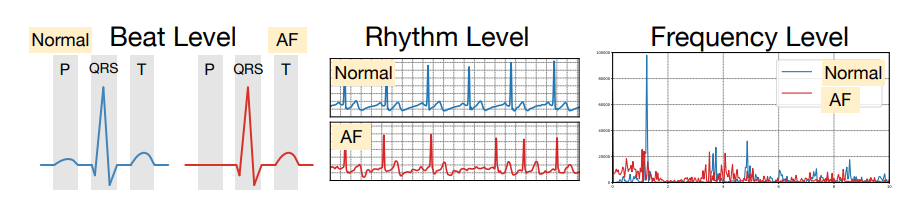

In [11]:
from IPython.display import Image, display
display(Image(filename=image_path))

### 1.2 Load the Data

Due to the resource constraints, the data and knowledge features have already been computed. Let's load them below.

In [8]:
train_dict = pd.read_pickle(os.path.join(DATA_PATH, 'train.pkl'))
test_dict = pd.read_pickle(os.path.join(DATA_PATH, 'test.pkl'))

print(f"There are {len(train_dict['Y'])} training data, {len(test_dict['Y'])} test data")
print(f"Shape of X: {train_dict['X'][:, 0,:].shape} = (#channels, n)")
print(f"Shape of beat feature: {train_dict['K_beat'][:, 0, :].shape} = (#channels, n)")
print(f"Shape of rhythm feature: {train_dict['K_rhythm'][:, 0, :].shape} = (#channels, M)")
print(f"Shape of frequency feature: {train_dict['K_freq'][:, 0, :].shape} = (#channels, 1)")

There are 1696 training data, 425 test data
Shape of X: (4, 3000) = (#channels, n)
Shape of beat feature: (4, 3000) = (#channels, n)
Shape of rhythm feature: (4, 60) = (#channels, M)
Shape of frequency feature: (4, 1) = (#channels, 1)


Define a `ECGDataset` class, and then define the `DataLoader` as well.

In [12]:
from torch.utils.data import Dataset
class ECGDataset(Dataset):

    def __init__(self, data_dict):
        self.X = data_dict['X']
        self.K_beat = data_dict['K_beat']
        self.K_rhythm = data_dict['K_rhythm']
        self.K_freq = data_dict['K_freq']
        self.Y = data_dict['Y']


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, i):
        X = self.X[:, i, :]
        K_beat = self.K_beat[:, i, :]
        K_rhythm = self.K_rhythm[:, i, :]
        K_freq = self.K_freq[:, i, :]
        Y = self.Y[i]
        return (X, K_beat, K_rhythm, K_freq), Y


from torch.utils.data import DataLoader
def load_data(dataset, batch_size=128):
    """
    Return a DataLoader instance basing on a Dataset instance, with batch_size specified.
    """
    def my_collate(batch):
        X = torch.stack([torch.tensor(item[0][0], dtype=torch.float) for item in batch], dim=1)
        K_beat = torch.stack([torch.tensor(item[0][1], dtype=torch.float) for item in batch], dim=1)
        K_rhythm = torch.stack([torch.tensor(item[0][2], dtype=torch.float) for item in batch], dim=1)
        K_freq = torch.stack([torch.tensor(item[0][3], dtype=torch.float) for item in batch], dim=1)
        Y = torch.tensor([item[1] for item in batch], dtype=torch.long)
        return (X, K_beat, K_rhythm, K_freq), Y

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate)


train_loader = load_data(ECGDataset(train_dict))
test_loader = load_data(ECGDataset(test_dict))

In [30]:
assert len(train_loader.dataset) == 1696, "Length of training data incorrect."
assert len(train_loader) == 14, "Length of the training dataloader incorrect - maybe check batch_size"
assert [x.shape for x in train_loader.dataset[0][0]] == [(4,3000), (4,3000), (4,60), (4,1)], "Shapes of the data don't match. Check __getitem__ implementation"

## 2 Model Defintions

Now, a model that involves RNN, CNN and attention mechanism is implemented. More specifically, implemented [MINA: Multilevel Knowledge-Guided Attention for Modeling Electrocardiography Signals](https://www.ijcai.org/Proceedings/2019/0816.pdf).

### 2.1 Knowledge-guided attention
Knowledge-guided attention is an attention mechanism that introduces prior knowledge (such as features proposed by human experts) in the features used by the attention mechanism. We will first define the general KnowledgeAttn module, and use it at different levels later.

There are three steps:
* 1\. concatenate the input ($X$) and knowledge ($K$).
* 2\. pass it through a linear layer, a tanh, another linear layer, and softmax: $attn = softmax(V^\top \tanh(W^\top \begin{bmatrix}X\\K\end{bmatrix}))$
* 3\. use attention values to sum $X$: $output = \sum_{i=1}^D attn_i x_i$ where $attn_i$ is a scalar and $x_i$ is a vector.

In [14]:
import torch.nn.functional as F

class KnowledgeAttn(nn.Module):
    def __init__(self, input_features, attn_dim):
        """
        This is the general knowledge-guided attention module.
        It will transform the input and knowledge with 2 linear layers, computes attention, and then aggregate.
        :param input_features: the number of features for each
        :param attn_dim: the number of hidden nodes in the attention mechanism
            define the following 2 linear layers WITHOUT bias (with the names provided)
                att_W: a Linear layer of shape (input_features + n_knowledge, attn_dim)
                att_v: a Linear layer of shape (attn_dim, 1)
            init the weights using self.init() (already given)
        """
        super(KnowledgeAttn, self).__init__()
        self.input_features = input_features
        self.attn_dim = attn_dim
        self.n_knowledge = 1

        # your code here
        self.att_W = nn.Linear(self.input_features + self.n_knowledge, self.attn_dim, bias=False)
        self.att_v = nn.Linear(self.attn_dim, 1, bias=False)

        self.init()

    def init(self):
        nn.init.normal_(self.att_W.weight)
        nn.init.normal_(self.att_v.weight)

    @classmethod
    def attention_sum(cls, x, attn):
        """

        :param x: of shape (-1, D, nfeatures)
        :param attn: of shape (-1, D, 1)
        return the weighted sum of x along the middle axis with weights even in attn. output shoule be (-1, nfeatures)
        """
        weighted_x = x * attn
        sum_weighted_x = torch.sum(weighted_x, dim=1)  # Sum over the middle dimension
        return sum_weighted_x.squeeze(1)  # Remove the middle dimension

    def forward(self, x, k):
        """
        :param x: shape of (-1, D, input_features)
        :param k: shape of (-1, D, 1)
        :return:
            out: shape of (-1, input_features), the aggregated x
            attn: shape of (-1, D, 1)
            concatenate the input x and knowledge k together (on the last dimension)
            pass the concatenated output through the learnable Linear transforms
                first att_W, then tanh, then att_v
                the output shape should be (-1, D, 1)
            to get attention values, apply softmax on the output of linear layer
                You could use F.softmax(). Be careful which dimension you apply softmax over
            aggregate x using the attention values via self.attention_sum, and return
        """
        combined = torch.cat((x, k), dim=-1)

        attn_raw = self.att_v(torch.tanh(self.att_W(combined)))
        attn = F.softmax(attn_raw, dim=1)
        out = self.attention_sum(x, attn)

        return out, attn

In [31]:
def float_tensor_equal(a, b, eps=1e-3):
    return torch.norm(a-b).abs().max().tolist() < eps

def testKnowledgeAttn():
    m = KnowledgeAttn(2, 2)
    m.att_W.weight.data = torch.tensor([[0.3298,  0.7045, -0.1067],
                                        [0.9656,  0.3090,  1.2627]], requires_grad=True)
    m.att_v.weight.data = torch.tensor([[-0.2368,  0.5824]], requires_grad=True)

    x = torch.tensor([[[-0.6898, -0.9098], [0.0230,  0.2879], [-0.2534, -0.3190]],
                      [[ 0.5412, -0.3434], [0.0289, -0.2837], [-0.4120, -0.7858]]])
    k = torch.tensor([[ 0.5469,  0.3948, -1.1430], [0.7815, -1.4787, -0.2929]]).unsqueeze(2)
    out, attn = m(x, k)

    tout = torch.tensor([[-0.2817, -0.2531], [0.2144, -0.4387]])
    tattn = torch.tensor([[[0.3482], [0.4475], [0.2043]],
                          [[0.5696], [0.1894], [0.2410]]])
    assert float_tensor_equal(attn, tattn), "The attention values are wrong"
    assert float_tensor_equal(out, tout), "output of the attention module is wrong"

testKnowledgeAttn()

### 2.2 MINA

We will now use the **knowledge-guided attention mechanism** to construct MINA. The overall structure is show below. From "Input" to "Sliding Window Segmentation" has already been done in the data preprocessing part, and in this section we will need to define things above "Segment"



Here, CNN (`BeatNet`) is used to capture beat information, Bi-LSTM (`RhythmNet`) is used to capture rhythm level information, and the from $c^{(i)}$ to $p$ is aggregating frequency levle infomration (`FreqNet`). Note that although the input has 4 channels, we actually need to handle each channel separately because they have different meanings after we did the FIR. Thus, we will need 4 `BeatNet`s, 4 `RhythmNet`s, and 1 `FreqNet`.


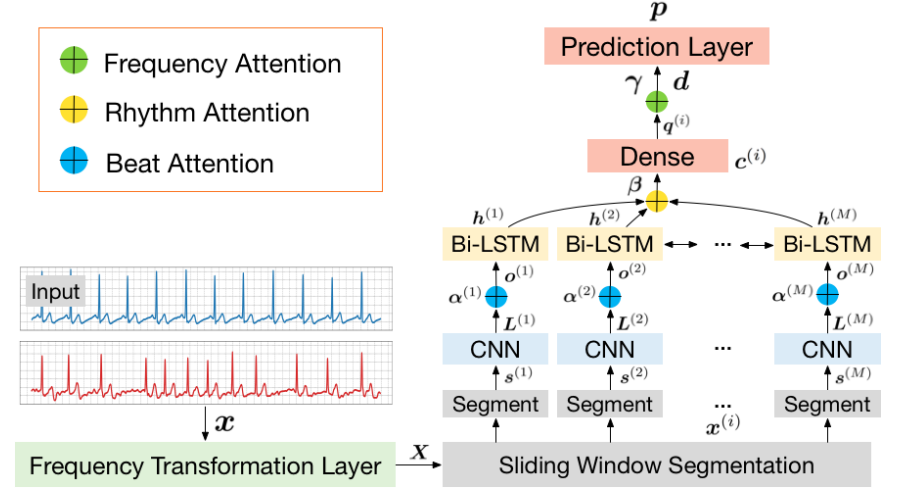

In [27]:
display(Image(filename="/content/drive/MyDrive/dl4h/MINA-lib/MINA_structure.png"))

MINA has three different knowledge guided attention mechanisms:
 - Beat Level $K_{beat}$: extract beat knowledge which is represented by the first-order difference and a convolutional operation $Conv_\alpha$ for each segment
 - Rhythm Level $K_{rhythn}$: extract rhythm features represented by the standard deviation on each segment
 - Frequency Level $K_{freq}$: frequency features are represented by the power spectral density (PSD), which is a popular measure of energy in signal processing.

#### 2.2.1 BeatNet
For BeatNet, the attention $\alpha$ is computed by the following:
$$\alpha = softmax(V_\alpha^\top \tanh(W_\alpha^\top \begin{bmatrix} \mathbf{L}\\\mathbf{K}_{beat} \end{bmatrix}))
$$
Here, $L$ is output by the convolutional layers, and $K_{beat}$ is the computed beat level knowledge features.

In [16]:
class BeatNet(nn.Module):
    #Attention for the CNN step/ beat level/local information
    def __init__(self, n=3000, T=50,
                 conv_out_channels=64):
        """
        :param n: size of each 10-second-data
        :param T: size of each smaller segment used to capture local information in the CNN stage
        :param conv_out_channels: also called number of filters/kernels
        define a network that does two things. Specifically:
            1. use one 1-D convolutional layer to capture local informatoin, on x and k_beat (see forward())
                conv: The kernel size should be set to 32, and the number of filters should be set to *conv_out_channels*. Stride should be *conv_stride*
                conv_k: same as conv, except that it has only 1 filter instead of *conv_out_channels*
            2. an attention mechanism to aggregate the convolution outputs. Specifically:
                attn: KnowledgeAttn with input_features equaling conv_out_channels, and attn_dim=att_cnn_dim
        """
        super(BeatNet, self).__init__()
        self.n, self.M, self.T = n, int(n/T), T
        self.conv_out_channels = conv_out_channels
        self.conv_kernel_size = 32
        self.conv_stride = 2

        #Define conv and conv_k, the two Conv1d modules
        self.conv = nn.Conv1d(1, conv_out_channels, self.conv_kernel_size, stride=self.conv_stride)
        self.conv_k = nn.Conv1d(1, 1, self.conv_kernel_size, stride=self.conv_stride)

        self.att_cnn_dim = 8
        #Define attn, the KnowledgeAttn module
        self.attn = KnowledgeAttn(conv_out_channels, self.att_cnn_dim)

    def forward(self, x, k_beat):
        """
        :param x: shape (batch, n)
        :param k_beat: shape (batch, n)
        :return:
            out: shape (batch, M, self.conv_out_channels)
            alpha: shape (batch * M, N, 1) where N is a result of convolution
        """
        x = x.view(-1, self.T).unsqueeze(1)
        k_beat = k_beat.view(-1, self.T).unsqueeze(1)

        # Apply convolutions
        conv_x = F.relu(self.conv(x))
        conv_k_beat = F.relu(self.conv_k(k_beat))

        conv_x = conv_x.permute(0, 2, 1)
        conv_k_beat = conv_k_beat.permute(0, 2, 1)

        out, alpha = self.attn(conv_x, conv_k_beat)

        out = out.view(-1, self.M, self.conv_out_channels)
        return out, alpha

In [32]:
_testm = BeatNet(12 * 34, 34, 56)
assert isinstance(_testm.conv, torch.nn.Conv1d) and isinstance(_testm.conv_k, torch.nn.Conv1d), "Should use nn.Conv1d"
assert _testm.conv.bias.shape == torch.Size([56]) and _testm.conv.weight.shape == torch.Size([56,1,32]), "conv definition is incorrect"
assert _testm.conv_k.bias.shape == torch.Size([1]) and _testm.conv_k.weight.shape == torch.Size([1, 1, 32]), "conv_k definition is incorrect"
assert isinstance(_testm.attn, KnowledgeAttn), "Should use one KnowledgeAttn Module"

_out, _alpha =_testm(torch.randn(37, 12*34), torch.randn(37, 12*34))
assert _alpha.shape == torch.Size([444,2,1]), "The attention's dimension is incorrect"
assert _out.shape==torch.Size([37, 12,56]), "The output's dimension is incorrect"
del _testm, _out, _alpha

#### 2.2.2 RhythmNet
For Rhythm, the attention $\beta$ is computed by the following:
$$\beta = softmax(V_\beta^\top \tanh(W_\beta^\top \begin{bmatrix} \mathbf{H}\\\mathbf{K}_{rhythm} \end{bmatrix}))
$$
Here, $\mathbf{H}$ is output by the Bi-LSTMs, and $K_{rhythm}$ is the computed rhythm level knowledge features.

In [18]:
class RhythmNet(nn.Module):
    def __init__(self, n=3000, T=50, input_size=64, rhythm_out_size=8):
        """
        :param n: size of each 10-second-data
        :param T: size of each smaller segment used to capture local information in the CNN stage
        :param input_size: This is the same as the # of filters/kernels in the CNN part.
        :param rhythm_out_size: output size of this netowrk
        define a network that does two things to handle rhythms. Specifically:
            1. use a bi-directional LSTM to process the learned local representations from the CNN part
                lstm: bidirectional, 1 layer, batch_first, and hidden_size should be set to *rnn_hidden_size*
            2. an attention mechanism to aggregate the convolution outputs. Specifically:
                attn: KnowledgeAttn with input_features equaling lstm output, and attn_dim=att_rnn_dim
            3. output layers
                fc: a Linear layer making the output of shape (..., self.out_size)
                do: a Dropout layer with p=0.5
        """
        #input_size is the cnn_out_channels
        super(RhythmNet, self).__init__()
        self.n, self.M, self.T = n, int(n/T), T
        self.input_size = input_size

        self.rnn_hidden_size = 32
        ### define lstm: LSTM Input is of shape (batch size, M, input_size)
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.rnn_hidden_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        # Attention mechanism: define attn to be a KnowledgeAttn
        self.att_rnn_dim = 8
        self.attn = KnowledgeAttn(2 * self.rnn_hidden_size, self.att_rnn_dim)

        # Define the Dropout and fully connecte layers (fc and do)
        self.out_size = rhythm_out_size
        self.fc = nn.Linear(2 * self.rnn_hidden_size, self.out_size)
        self.do = nn.Dropout(p=0.5)


    def forward(self, x, k_rhythm):
        """
        :param x: shape (batch, M, self.input_size)
        :param k_rhythm: shape (batch, M)
        :return:
            out: shape (batch, self.out_size)
            beta: shape (batch, M, 1)

            reshape the k_rhythm->(batch, M, 1) (HINT: use k_rhythm.unsqueeze())
            pass the reshaped x through lstm
            pass the lstm output and knowledge through attn
            pass the result through fully connected layer - ReLU - Dropout
            denote the final output as *out*, and the attention output as *beta*
        """

        k_rhythm = k_rhythm.unsqueeze(-1)
        lstm_out, _ = self.lstm(x)
        out, beta = self.attn(lstm_out, k_rhythm)
        out = self.do(F.relu(self.fc(out)))

        return out, beta

In [33]:
_B, _M, _T = 17, 23, 31
_testm = RhythmNet(_M * _T, _T, 37)
assert isinstance(_testm.lstm, torch.nn.LSTM), "Should use nn.LSTM"
assert _testm.lstm.bidirectional, "LSTM should be bidirectional"
assert isinstance(_testm.attn, KnowledgeAttn), "Should use one KnowledgeAttn Module"
assert isinstance(_testm.fc, nn.Linear) and _testm.fc.weight.shape == torch.Size([8,64]), "The fully connected is incorrect"
assert isinstance(_testm.do, nn.Dropout), "Dropout layer is not defined correctly"

_out, _beta = _testm(torch.randn(_B, _M, 37), torch.randn(_B, _M))
assert _beta.shape == torch.Size([_B,_M,1]), "The attention's dimension is incorrect"
assert _out.shape==torch.Size([_B, 8]), "The output's dimension is incorrect"
del _testm, _out, _beta,  _B, _M, _T

#### 2.2.3 FreqNet
The attention $\gamma$ is computed by the following:
$$
\gamma = \text{softmax}\left(V_\gamma^\top \tanh\left(W_\gamma^\top \begin{bmatrix} \mathbf{Q} \\ \mathbf{K}_{\text{freq}} \end{bmatrix}\right)\right)
$$

Here, $\mathbf{Q}$ is output of the RhythmNets, and $K_{freq}$ is the computed frequency level knowledge features.

In [20]:
class FreqNet(nn.Module):
    def __init__(self, n_channels=4, n=3000, T=50):
        """
        :param n_channels: number of channels (F in the paper). We will need to define this many BeatNet & RhythmNet nets.
        :param n: size of each 10-second-data
        :param T: size of each smaller segment used to capture local information in the CNN stage
        This is the main network that orchestrates the previously defined attention modules:
            1. define n_channels many BeatNet and RhythmNet modules. (Hint: use nn.ModuleList)
                beat_nets: for each beat_net, pass parameter conv_out_channel into the init()
                rhythm_nets: for each rhythm_net, pass conv_out_channel as input_size, and self.rhythm_out_size as the output size
            2. define frequency (channel) level knowledge-guided attention module
                attn: KnowledgeAttn with input_features equaling rhythm_out_size, and attn_dim=att_channel_dim
            3. output layer: a Linear layer for 2 classes output
        """
        super(FreqNet, self).__init__()
        self.n, self.M, self.T = n, int(n / T), T
        self.n_class = 2
        self.n_channels = n_channels
        self.conv_out_channels=64
        self.rhythm_out_size=8

        self.beat_nets = nn.ModuleList([
            BeatNet(n=self.n, T=self.T, conv_out_channels=self.conv_out_channels)
            for _ in range(n_channels)
        ])
        self.rhythm_nets = nn.ModuleList([
            RhythmNet(n=self.n, T=self.T, input_size=self.conv_out_channels, rhythm_out_size=self.rhythm_out_size)
            for _ in range(n_channels)
        ])


        self.att_channel_dim = 2
        #Add the frequency attention module using KnowledgeAttn (attn)
        self.attn = KnowledgeAttn(self.rhythm_out_size, self.att_channel_dim)
        #Create the fully-connected output layer (fc)
        self.fc = nn.Linear(self.rhythm_out_size, 2)


    def forward(self, x, k_beats, k_rhythms, k_freq):
        """
        We need to use the attention submodules to process data from each channel separately, and then pass the
            output through an attention on frequency for the final output

        :param x: shape (n_channels, batch, n)
        :param k_beats: (n_channels, batch, n)
        :param k_rhythms: (n_channels, batch, M)
        :param k_freq: (n_channels, batch, 1)
        :return:
            out: softmax output for each data point, shpae (batch, n_class)
            gama: the attention value on channels
            1. pass each channel of x through the corresponding beat_net, then rhythm_net.
                will discard the attention (alpha and beta) outputs for now
                Using ModuleList for self.beat_nets/rhythm_nets is necessary for the gradient to propagate
            2. stack the output from 1 together into a tensor of shape (batch, n_channels, rhythm_out_size)
            3. pass result from 2 and k_freq through attention module, to get the aggregated result and *gama*
                You might need to do use k_freq.permute() to tweak the shape of k_freq
            4. pass aggregated result from 3 through the final fully connected layer.
            5. Apply Softmax to normalize output to a probability distribution (over 2 classes)
        """
        new_x = [None for _ in range(self.n_channels)]
        for i in range(self.n_channels):
            tx, _ = self.beat_nets[i](x[i], k_beats[i])
            new_x[i], _ = self.rhythm_nets[i](tx, k_rhythms[i])
        x = torch.stack(new_x, 1)  # [128,8] -> [128,4,8]

        k_freq_permuted = k_freq.permute(1, 0, 2)  # shape: (batch, n_channels, 1)
        attn_aggregated, gamma = self.attn(x, k_freq_permuted)
        out = self.fc(attn_aggregated)
        out = F.softmax(out, dim=1)

        return out, gamma

In [34]:
_B, _M, _T = 17, 59, 109
_testm = FreqNet(n=_M * _T, T=_T)
assert isinstance(_testm.attn, KnowledgeAttn), "Should use one KnowledgeAttn Module"
assert isinstance(_testm.fc, nn.Linear) and _testm.fc.weight.shape == torch.Size([2,8]), "The fully connected is incorrect"
assert isinstance(_testm.beat_nets, nn.ModuleList), "beat_nets has to be a ModuleList"

_out, _gamma = _testm(torch.randn(4, _B, _M * _T), torch.randn(4, _B, _M * _T), torch.randn(4, _B, _M), torch.randn(4, _B, 1))
assert _gamma.shape == torch.Size([_B, 4, 1]), "The attention's dimension is incorrect"
assert _out.shape==torch.Size([_B, 2]), "The output's dimension is incorrect"
del _testm, _out, _gamma,  _B, _M, _T

## 3 Training and Evaluation
In this part we will define the training procedures, train the model, and evaluate the model on the test set.

In [22]:
def train_model(model, train_dataloader, n_epoch=5, lr=0.003, device=None):
    import torch.optim as optim
    """
    :param model: The instance of FreqNet that we are training
    :param train_dataloader: the DataLoader of the training data
    :param n_epoch: number of epochs to train
    :return:
        model: trained model
        loss_history: recorded training loss history - should be just a list of float

        Specify the optimizer (*optimizer*) to be optim.Adam
        Specify the loss function (*loss_func*) to be CrossEntropyLoss
        Within the loop, do the normal training procedures:
            pass the input through the model
            pass the output through loss_func to compute the loss
            zero out currently accumulated gradient, use loss.basckward to backprop the gradients, then call optimizer.step
    """
    device = device or torch.device('cpu')
    model.to(device)
    model.train()

    loss_history = []

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for (X, K_beat, K_rhythm, K_freq), Y in train_dataloader:
            X, K_beat, K_rhythm, K_freq, Y = X.to(device), K_beat.to(device), K_rhythm.to(device), K_freq.to(device), Y.to(device)
            # Forward pass
            outputs, _ = model(X, K_beat, K_rhythm, K_freq)
            loss = loss_func(outputs, Y)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"epoch{epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        loss_history += curr_epoch_loss
    return model, loss_history

def eval_model(model, dataloader, device=None):
    """
    :return:
        pred_all: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints

        evaluate the model using on the data in the dataloder.
        Add all the prediction and truth to the corresponding list
        Convert pred_all and Y_test to numpy arrays (of shape (n_data_points, 2))
    """
    device = device or torch.device('cpu')
    model.to(device)
    model.eval()
    pred_all = []
    Y_test = []
    for (X, K_beat, K_rhythm, K_freq), Y in dataloader:
        X, K_beat, K_rhythm, K_freq = X.to(device), K_beat.to(device), K_rhythm.to(device), K_freq.to(device)

        outputs, _ = model(X, K_beat, K_rhythm, K_freq)
        preds = outputs.detach().cpu().numpy()
        labels = Y.cpu().numpy()

        pred_all.append(preds)
        Y_test.append(labels)

    pred_all = np.concatenate(pred_all, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return pred_all, Y_test

In [23]:
device = torch.device('cpu')
n_epoch = 4
lr = 0.003
n_channel = 4
n_dim=3000
T=50

model = FreqNet(n_channel, n_dim, T)
model = model.to(device)

model, loss_history = train_model(model, train_loader, n_epoch=n_epoch, lr=lr, device=device)
pred, truth = eval_model(model, test_loader, device=device)

epoch0: curr_epoch_loss=0.6891258358955383
epoch1: curr_epoch_loss=0.6540995240211487
epoch2: curr_epoch_loss=0.5974910855293274
epoch3: curr_epoch_loss=0.5332108736038208


In [28]:
def evaluate_predictions(truth, pred):
    """
     Evaluate the performance of the predictoin via AUROC, and F1 score
    each prediction in pred is a vector representing [p_0, p_1].
    When defining the scores we are interesed in detecting class 1 only
    return: auroc, f1
    """
    from sklearn.metrics import roc_auc_score, f1_score

    pred_prob_class_1 = pred[:, 1]
    auroc = roc_auc_score(truth, pred_prob_class_1)
    pred_labels_class_1 = (pred_prob_class_1 > 0.5).astype(int)
    f1 = f1_score(truth, pred_labels_class_1)

    return auroc, f1

In [29]:
pred, truth = eval_model(model, test_loader, device=device)
auroc, f1 = evaluate_predictions(truth, pred)
print(f"AUROC={auroc} and F1={f1}")

assert auroc > 0.8 and f1 > 0.7, "Performance is too low {}. Something's probably off.".format((auroc, f1))

AUROC=0.9021064301552106 and F1=0.7864583333333335
